In [1]:
import librosa
import librosa.display
import audiolazy

from midiutil import MIDIFile
from glob import glob
from audiolazy import str2midi

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import math

### 만든 함수

#### Mapping_example

In [2]:
def map_value(value, min_value, max_value, min_result, max_result):
    '''maps value (or array of values) from one range to another'''
    
    result = min_result + (value - min_value)/(max_value - min_value)*(max_result - min_result)
    return result

#### Mapping Frequencies

In [3]:
def map_freq (value):
    

SyntaxError: unexpected EOF while parsing (1330565951.py, line 2)

#### Time data 받기

In [4]:
def SR_point(data):
    result = list(range(len(data)))
    return result

## 음향정보 받아오기

In [5]:
music_files = glob('./audio-data-processing/music_data/*.wav')
music_files

['./audio-data-processing/music_data\\Axollo-Burn_It.wav',
 './audio-data-processing/music_data\\Curbi-What_You_Like.wav',
 './audio-data-processing/music_data\\Robin_Hustin_Jessica_Chertock-Burn_it_Down.wav',
 './audio-data-processing/music_data\\Slow-ambient-new-age-song.wav']

In [6]:
y , sr = librosa.load(music_files[3])
length_in_sec = y.shape[0]/sr

In [7]:
time = np.arange(y.shape[0])/y.shape[0]*length_in_sec

In [8]:
y_stft = librosa.stft(y)
y_stft.shape

(1025, 11344)

In [10]:
len(y_stft[0])

11344

##### https://www.tutorialexample.com/understand-n_fft-hop_length-win_length-in-audio-processing-librosa-tutorial/

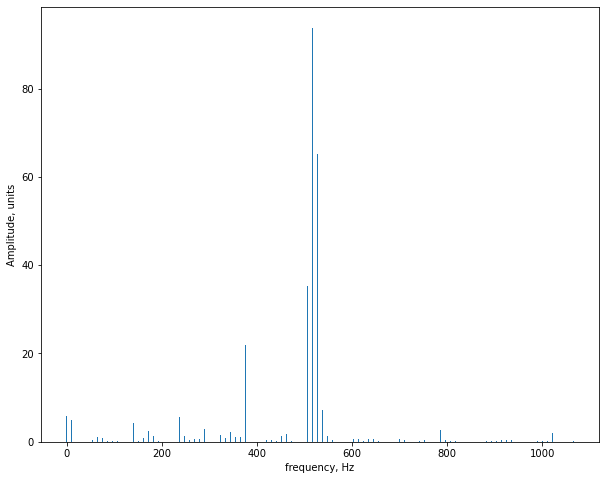

In [18]:
test_Y = y_stft[:,346]  # window 2048, unit = 22050, stride = 1024 
test_Y_abs = np.abs(test_Y)
test_freq = np.fft.fftfreq(y_stft[:,43].size, d=1./int(22050 * 0.5)) ## sample rate = 분해능, Window를 바탕으로 다시 Hz를 해석하기에 해석가능한 주파수는 Sample rate의  반이다.
                                                                     ## sample rate에 window kenght의 scale을 곱해 FT의 값을 맞추는게 맞다고 하는데 단위가 다르다.. 

# fft_spectrum = np.fft.rfft(y)
# fft_spectrum_abs = np.abs(fft_spectrum)
# freq = np.fft.rfftfreq(y.size, d=1./sr)
plt.figure(figsize = (10,8))
plt.bar(test_freq[0:100], test_Y_abs[0:100],width = 1.5)
plt.xlim()
plt.ylim()
plt.xlabel("frequency, Hz")
plt.ylabel("Amplitude, units")
plt.show()

### 주파수 찾는 함수
 - 음들 중 몇몇의 큰 Amplitude값을 가진 음만을 사용할 예정

#### data sheet 단위로 음을 찾는 함수

In [12]:
 # used_Freq_in_ = []   # 뭐라고 적어야 할 지 몰라 빈칸을 적었는데, 1/43초 임
def findFreq_by_Datapoint(Freq, Amp_abs):
    
    n_freq = int(len(Freq) / 2) # 0 부터 Max Freq 까지 간 다음 MinFreq 부터 0 까지 data를 받기 때문에 + 데시벨은 굳이 받아야 하나 싶다.
    n_freq = n_freq - n_freq%5  ## 3000 이상의 고주파는 굳이 사용하고싶은 생각이 없어서 Freq를 찾을 때 방해되지않게 날려버림
    
    Freq_carrier = Freq[:n_freq]
    Amp_abs_carrier = Amp_abs[:n_freq]  
    
    Freq_carrier = np.reshape(Freq_carrier, (-1,5)) 
    Amp_abs_carrier = np.reshape(Amp_abs_carrier,(-1,5)) # 그 시간에 사용한 음을 명확하게 가져오기 위해 주변음 중 최댓값을 이용할 예정

    Freq_box = {}

    for i in range(n_freq // 5):

        max_Amp = max(Amp_abs_carrier[i]) # 최댓값

        if max_Amp <= 10:
            continue

        max_Amp_idx = Amp_abs_carrier[i].argmax() # 그 때의 idx
        local_max_Freq = Freq_carrier[i][max_Amp_idx]
        Freq_box[local_max_Freq] = max_Amp

    return Freq_box

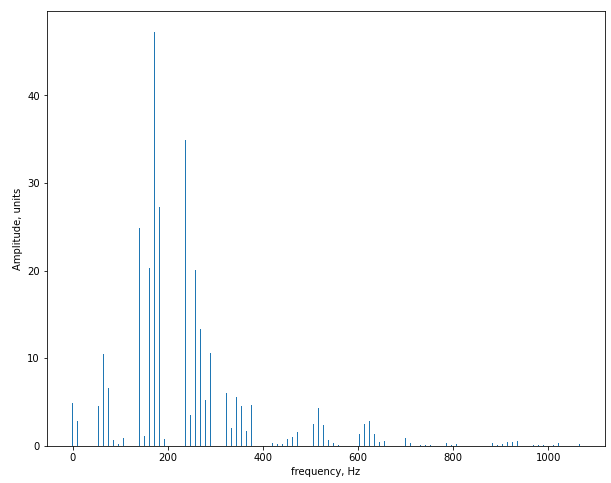
 - 이 사진은 예시인데, 보는 바와같이 주변에도 소리가 존재해 모든 주파수를 가져오면 곤란한 면이 있다.

#### 구한 Freq_box를 timepoint에 저장하는 함수

In [15]:
def Used_Freq_in_(Y_STFT, sr = 22050):
    n_time_data = len(y_stft[0])
    used_Freq_in_ = [] 
    
    for i in range(n_time_data):
        
        amp_abs = np.abs(y_stft[:,i])
        y_stft_freq = np.fft.fftfreq(y_stft[:,i].size, d=1./int(sr * 0.5))

        used_Freq_in_.append([i, findFreq_by_Datapoint(y_stft_freq, amp_abs)])
    
    return used_Freq_in_

In [16]:
Used_Freq_in_(y_stft)

[[0, {}],
 [1, {}],
 [2, {}],
 [3, {}],
 [4, {129.0731707317073: 23.708548}],
 [5,
  {129.0731707317073: 32.094658,
   258.1463414634146: 10.266888,
   311.9268292682927: 10.650929}],
 [6,
  {64.53658536585365: 10.476146,
   129.0731707317073: 34.49674,
   258.1463414634146: 11.546207,
   311.9268292682927: 10.07483}],
 [7,
  {64.53658536585365: 11.919179,
   129.0731707317073: 35.86715,
   258.1463414634146: 10.751743}],
 [8, {64.53658536585365: 12.501668, 129.0731707317073: 36.37188}],
 [9, {64.53658536585365: 12.776109, 129.0731707317073: 36.051754}],
 [10,
  {64.53658536585365: 12.61945,
   129.0731707317073: 35.000175,
   236.6341463414634: 10.59994}],
 [11,
  {64.53658536585365: 12.678156,
   129.0731707317073: 33.714787,
   236.6341463414634: 12.957831}],
 [12,
  {64.53658536585365: 13.414576,
   129.0731707317073: 33.487198,
   258.1463414634146: 15.639713,
   301.1707317073171: 13.135355}],
 [13,
  {64.53658536585365: 14.007213,
   129.0731707317073: 34.176926,
   258.14634146

### END

In [19]:
abs_ystft = np.abs(y_stft)
print(abs_ystft[0])

[0.0000000e+00 8.1832572e-05 1.2687266e-01 ... 1.2688655e-04 5.2377542e-05
 3.2472415e-06]


In [23]:
a = y_stft[:,:350]

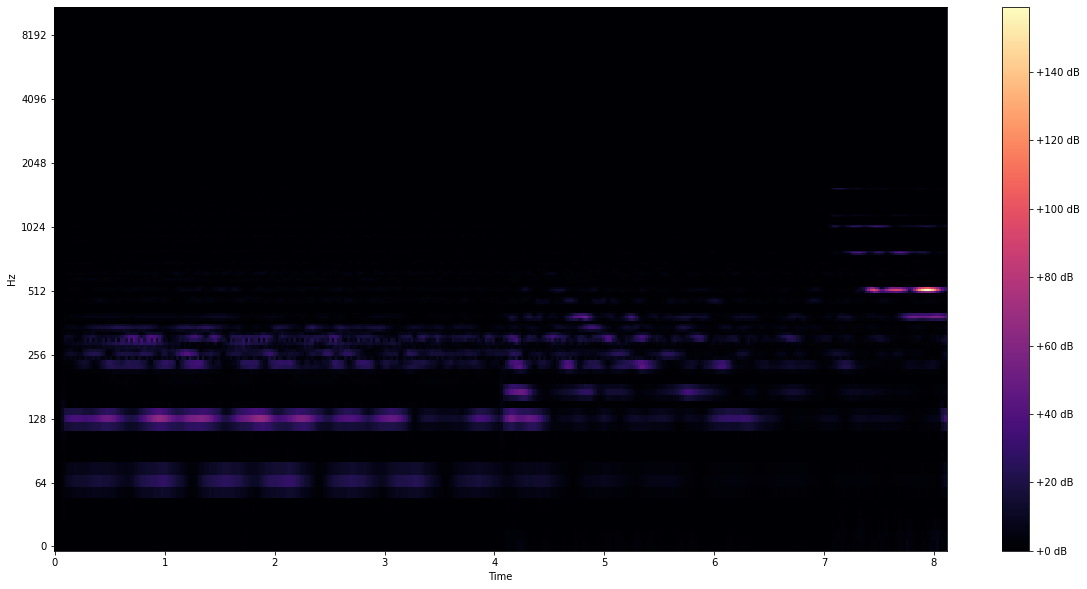

In [24]:
fig, ax = plt.subplots(figsize = (20,10))
img = librosa.display.specshow(a, x_axis = 'time', y_axis='log',ax = ax)
fig.colorbar(img, ax=ax, format="%+2.0f dB")
plt.show()

### sr는 sample rate로 1초당 데이터를 얼마나 분할한지 확인 가능

In [ ]:
print(y.shape)
print(sr)


test = int(y.shape[0]/sr)
test

#### bpm을 기준으로 단위로 새롭게 resample 해서 beat음을 받을까 생각중

##### 4분음표 기준 0.5초, librosa 기준 1초에 22050의 데이터 포인트가 default

#### 음향 정보 잠깐 확인

In [ ]:
muzdata_normalized = map_value(y, min(y),max(y),0,2)

muz_norm_head = muzdata_normalized[0:100]


In [ ]:
sr_point = SR_point(muz_norm_head)

plt.scatter(sr_point, y[0:100], s = 1)

### note data 받아오기

In [ ]:
note_names = ['C1','D1','E1','G1','A1',
             'C2','D2','E2','G2','A2',
             'C3','D3','E3','G3','A3',
             'C4','D4','E4','G4','A4',
             'C5','D5','E5','G5','A5',
             'C6','D6','E6','G6','A6']

note_names = ['C1','D1','E1','F1','G1','A1','B1',
             'C2','D2','E2','F2','G2','A2','B2',
             'C3','D3','E3','F3','G3','A3','B3',
             'C4','D4','E4','F4','G4','A4','B4',
             'C5','D5','E5','F5','G5','A5','B5',
             'C6','D6','E6','F6','G6','A6','B6']
note_midis = [str2midi(n) for n in note_names] #make a list of midi note numbers 

n_notes = len(note_midis)
print('Resolution:',n_notes, 'notes')
# if you want higher just choose more number of midis
print(note_midis)

In [ ]:
midi_data = []
for i in range(len(muz_norm_head)):
    note_index = round(map_value(muz_norm_head[i], min(muz_norm_head), max(muz_norm_head), n_notes-1, 0))
    
    midi_data.append(note_midis[note_index])
